# Outline

1. [The tree sequence format](ts_workshop_part1.ipynb#ts)
2. [Simulations with msprime and slim](#msprime)
3. [Calculating statistics with tree sequences](#stats)
4. [Inferring tree sequences (tsinfer)](ts_workshop_part3.ipynb#tsinfer)
5. [Metadata in tree sequences](ts_workshop_part3.ipynb#metadata)
6. [References and Documentation](ts_workshop_part3.ipynb#ref)

In [41]:
from IPython.display import SVG, display, HTML
import msprime
import pyslim # to interface with SLiM files 

In [42]:
%%html
<style>aside {color:grey;}</style>

<a id='msprime'></a>
# 2. Simulation

## Reverse-time simulations with `msprime`
The `msprime` program is an efficient reimplementation of Hudson's $\texttt{ms}$ simulator which outputs coalescent trees using the tree sequence format. The easiest way to use it is through the Python API, which is well documented at https://msprime.readthedocs.io/en/stable/api.html. 

Running simulations is very straightforward, and produces trees with branch lengths as expected under the full coalescent.

Number of Trees: 1


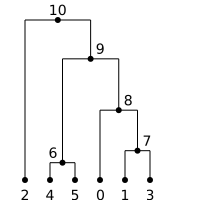

In [43]:
# simulate the coalescent for 6 samples, with effective population size of 10,000
# since the recombination rate defaults to zero, we should have only one tree
singular_tree_seq = msprime.simulate(sample_size=6, Ne=10000, random_seed=10)

# check there is only one tree in this ts
print("Number of Trees:",singular_tree_seq.num_trees)

#take the first (only) tree and visualize
first_tree=singular_tree_seq.first()
SVG(first_tree.draw())

Here, we simulate the coalescent for a sample of size six with an effective population size of 10000 diploids, and then print out a depiction of the resulting tree. The `simulate()` function returns a standard `TreeSequence` object. Here there is only one tree because we have not provided a value for recombination_rate, which therefore defaults to zero. We can access the first (and only) tree in this sequence using `first()` method of a `TreeSequence` object.

Note that although it is common for the lowest numbered nodes to correspond to the samples (i.e. tips of the trees, here with IDs 0 to 5) and the internal nodes to take higher values (e.g. the root node with ID 10), this may not always be the case e.g. in complex forward simulations or with ancient samples. Sometimes you may wish to check which node IDs correspond to samples, as follows:

In [44]:
singular_tree_seq.samples()

array([0, 1, 2, 3, 4, 5], dtype=int32)


Since the simulation was a basic one, the 6 samples take the first 6 node IDs. We can easily trace our path back to the root from a particular sample (e.g. the sample genome with ID 3) for any tree using the `parent()` method:

In [45]:
node_id = 3
while node_id != msprime.NULL_NODE:
  print("node {}: time = {}".format(node_id, first_tree.time(node_id)))
  node_id = first_tree.parent(node_id)

node 3: time = 0.0
node 7: time = 3332.0162387549144
node 8: time = 7937.08724150321
node 9: time = 13773.360032014867
node 10: time = 18187.861182446646


Here we have iterated up the tree starting at node 3, stopping when we reached the root. We know that a node is a root if its parent is `msprime.NULL_NODE`, which is a special reserved node. (The value of the null node is -1, but we recommend using the symbolic constant to make code more readable.) We also use the `time()` method to get the time for each node, which corresponds to the time in generations at which the coalescence event happened during the simulation. 

We can also obtain the length of a branch joining a node to its parent using the `branch_length()` method; the total branch length in the tree is also stored in the `total_branch_length` attribute: 

In [46]:
node = 7
print("Branch length above node", node, "is", first_tree.branch_length(node))
print("Total branch length in tree is", first_tree.total_branch_length)

Branch length above node 7 is 4605.0710027482955
Total branch length in tree is 63385.43180380048


### Recombination
Simulating the history of a single locus is a very useful, but we are most often interesting in simulating the history of our sample across large genomic regions under the influence of recombination. The msprime API is specifically designed to make this common requirement both easy and efficient. To model genomic sequences under the influence of recombination we have two parameters to the `simulate()` function. The length parameter specifies the length of the simulated sequence, and is a floating point number, so recombination (and mutation) can occur at any location along the sequence (the units are arbitrary). If length is not supplied, it is assumed to be 1.0. The recombination_rate parameter specifies the rate of crossing over per unit of length per generation, and is zero by default. See the [API Documentation](https://msprime.readthedocs.io/en/stable/api.html#variable-recombination-rates) for a discussion of the precise recombination model used, and how to implement variable recombination rates.

Here, we simulate the trees across over a 10kb region with a recombination rate of 2×10−8 per base per generation, with a diploid effective population size of 1000:

--------------------
tree 0: interval = (0.0, 2070.5408305093974)


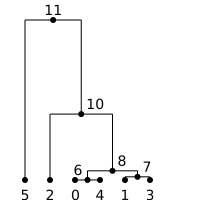

--------------------
tree 1: interval = (2070.5408305093974, 10000.0)


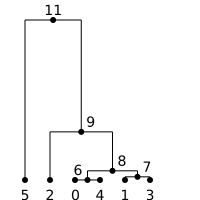

In [47]:
simple_tree_seq = msprime.simulate(
  sample_size=6, Ne=1000, length=1e4, recombination_rate=2e-8, random_seed=8)
for tree in simple_tree_seq.trees():
  print("-" * 20)
  print("tree {}: interval = {}".format(tree.index, tree.interval))
  display(SVG(tree.draw()))

As before, we use the `trees()` method to iterate over the trees in the sequence. For each tree we print out its index (i.e., its position in the sequence) and the interval the tree covers (i.e., the genomic coordinates which all share precisely this tree) using the index and interval attributes. Thus, the first tree covers the first 2kb of sequence, the second tree covers the remaining 4kb.

Note that this is a case where, although there has been a recombination event in the history of the samples, it has not changed the *topology* of the tree. Instead, it has changed the depth of one of the coalescent points: essentially, the subtree defined by node 10 has been pruned, and grafted back onto the same branch, a little lower down.

### Mutations
Mutations are generated in msprime by throwing mutations down on the branches of trees at a particular rate. The mutations are generated under the infinite sites model, and so each mutation occurs at a unique (floating point) point position along the genomic interval occupied by a tree. The mutation rate for simulations is specified using the mutation_rate parameter of `simulate()`. For example, the following chunk simulates 50kb of nonrecombining sequence with a mutation rate of 1×10−8 per base per generation:

Num trees: 1
Mutation 0 @ position 1556.54 over node 9
Mutation 1 @ position 4485.17 over node 6
Mutation 2 @ position 9788.56 over node 6
Mutation 3 @ position 11759.03 over node 6
Mutation 4 @ position 11949.32 over node 6
Mutation 5 @ position 14321.77 over node 9
Mutation 6 @ position 31454.99 over node 6
Mutation 7 @ position 45125.69 over node 9
Mutation 8 @ position 49709.68 over node 6


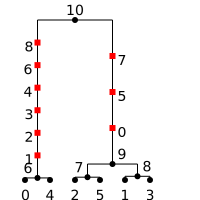

In [63]:
mut_tree_seq = msprime.simulate(
  sample_size=6, Ne=1000, length=50e3, mutation_rate=1e-8, random_seed=30)
print("Num trees:", mut_tree_seq.num_trees)
tree = mut_tree_seq.first()
for site in tree.sites():
  for mutation in site.mutations:
    print("Mutation {} @ position {:.2f} over node {}".format(
    mutation.id, site.position, mutation.node))
display(SVG(tree.draw()))

Mutations in the tree sequence lead to variable sites. By default, `msprime` creates mutations where the original (ancestral) state is `0` and the derived state is `1`. For example, in the above example, only samples 0 and 4 inherit the mutations *1* and *2* (which are at positions 4485.17 and 9788.56 along the sequence), meaning that they both have the variant `1` at those positions, whereas the other samples have the variant `0` at those positions.


Here you can see that the mutations plus tree are enough  to reconstruct the state of the variant sites for all samples. Thus the full tree sequence structure (which includes all mutations) encodes the full variant matrix. Often we do not need to actually deal with the variant matrix; nevertheless we will see  later in this notebook how to take a tree sequence and save the variant matrix as a VCF file or extract it (or the state of a specific variant) into a numpy array for further analysis.

### Population structure in `msprime`
`Msprime` provides a flexible and simple way to model past demographic events in arbitrary combinations. Here is an example, taken from the [`msprime` documentation](https://msprime.readthedocs.io/en/stable/tutorial.html#demography), describing the Gutenkunst et al. out-of-Africa model (2009). Figure 2B is a schematic of this model, reproduced below. See [Table 1](https://journals.plos.org/plosgenetics/article/figure?id=10.1371/journal.pgen.1000695.t001)  for the values used. Coalescent simulation moves from the present back into the past, so times are in units of generations ago, and we build the model with most recent events first.

The following is figure 2b from the paper:

<img style="width: 400px;" src="images/gutenkunst_cropped_fig2b.png">

In [64]:
import math
def out_of_africa():
    # First we set out the maximum likelihood values of the various parameters
    # given in Table 1.
    N_A = 7300
    N_B = 2100
 
    N_AF = 12300
    N_EU0 = 1000
    N_AS0 = 510
    
    # Times are provided in years, so we convert into generations.
    generation_time = 25
    T_AF = 220e3 / generation_time
    T_B = 140e3 / generation_time
    T_EU_AS = 21.2e3 / generation_time
    # We need to work out the starting (diploid) population sizes based on
    # the growth rates provided for these two populations
    r_EU = 0.004
    r_AS = 0.0055
    N_EU = N_EU0 / math.exp(-r_EU * T_EU_AS)
    N_AS = N_AS0 / math.exp(-r_AS * T_EU_AS)
    # Migration rates during the various epochs.
    m_AF_B = 25e-5
    m_AF_EU = 3e-5
    m_AF_AS = 1.9e-5
    m_EU_AS = 9.6e-5
    # Population IDs correspond to their indexes in the population
    # configuration array. Therefore, we have 0=YRI, 1=CEU and 2=CHB
    # initially.
    sim_result= dict(
        #we simulate two chromosomes from each population
        population_configurations = [
            msprime.PopulationConfiguration(
                sample_size=2, initial_size=N_AF),
            msprime.PopulationConfiguration(
                sample_size=2, initial_size=N_EU, growth_rate=r_EU),
            msprime.PopulationConfiguration(
                sample_size=2, initial_size=N_AS, growth_rate=r_AS)
        ],
        migration_matrix = [
            [      0, m_AF_EU, m_AF_AS],
            [m_AF_EU,       0, m_EU_AS],
            [m_AF_AS, m_EU_AS,       0],
        ],
        demographic_events = [
            # CEU and CHB merge into B with rate changes at T_EU_AS
            msprime.MassMigration(
                time=T_EU_AS, source=2, destination=1, proportion=1.0),
            msprime.MigrationRateChange(time=T_EU_AS, rate=0),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(0, 1)),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(1, 0)),
            msprime.PopulationParametersChange(
                time=T_EU_AS, initial_size=N_B, growth_rate=0, population_id=1),
            # Population B merges into YRI at T_B
            msprime.MassMigration(
                time=T_B, source=1, destination=0, proportion=1.0),
            # Size changes to N_A at T_AF
            msprime.PopulationParametersChange(
                time=T_AF, initial_size=N_A, population_id=0)
        ]
    )
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=sim_result["population_configurations"],
        migration_matrix=sim_result["migration_matrix"],
        demographic_events=sim_result["demographic_events"])
    dd.print_history()
    return(sim_result)

The DemographyDebugger provides a method to debug the history that you have described so that you can be sure that the migration rates, population sizes and growth rates are all as you intend during each epoch:

In [65]:
OOA_tree_seq = msprime.simulate(**out_of_africa(),
                              length=5e3, 
                              recombination_rate=1e-8, 
                              random_seed=11)

Epoch: 0 -- 848.0 generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |1.23e+04 1.23e+04              0 |     0      3e-05   1.9e-05 
1 |2.97e+04   1e+03           0.004 |   3e-05      0     9.6e-05 
2 |5.41e+04    510           0.0055 |  1.9e-05  9.6e-05     0    

Events @ generation 848.0
   - Mass migration: lineages move from 2 to 1 with probability 1.0
   - Migration rate change to 0 everywhere
   - Migration rate change for (0, 1) to 0.00025
   - Migration rate change for (1, 0) to 0.00025
   - Population parameter change for 1: initial_size -> 2100 growth_rate -> 0 
Epoch: 848.0 -- 5600.0 generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |1.23e+04 1.23e+04              0 |     0     0.00025     0    
1 | 2.1e+03  2.1e+03              0 |  0.00025     0        0    
2 |   510   2.27e-09      

Let's look at the output from running the simulation with the following parameters:

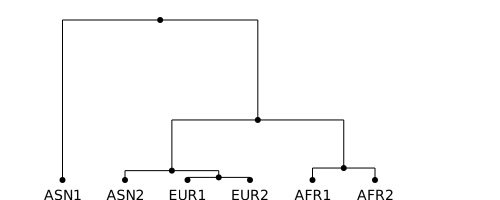

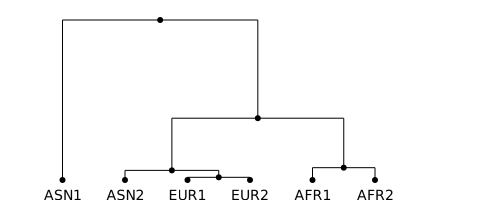

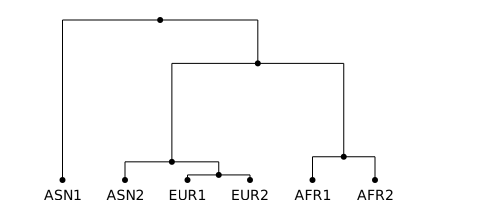

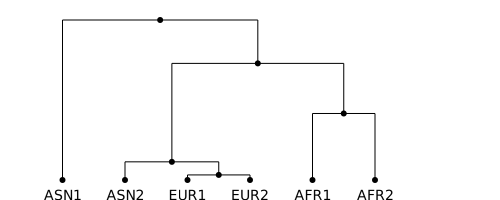

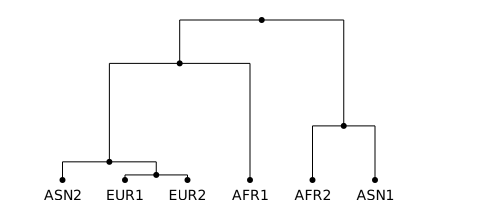

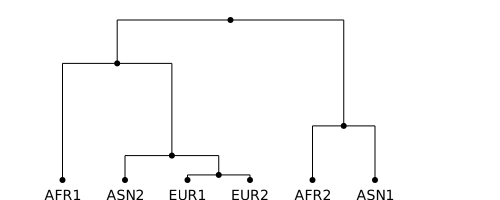

In [66]:
for tree in OOA_tree_seq.trees():
  display(SVG(tree.draw(mutation_labels={},
                        node_labels={0:"AFR1",1:"AFR2",
                                     2:"EUR1",3:"EUR2",4:"ASN1",5:"ASN2"},
                        width=500)))

### Saving files
Let's throw some mutations onto this genealogy, then save the resulting tree sequence file. We can also save the variants into a VCF file, which we will use when demonstrating `tsinfer` in section 4. 

In [67]:
# Add mutations to an existing tree sequence
OOA_with_mutations = msprime.mutate(OOA_tree_seq, rate=1e-6, random_seed=1, keep=True)

# Save the tree sequence file (recommended prefix is .trees)
OOA_with_mutations.dump("data/OOA.trees")

# Save as vcf
with open("data/3pop_simulation.vcf", "w") as vcf_file:
  OOA_with_mutations.write_vcf(vcf_file, 2)

## Forward Simulations with `SLiM`
Although msprime is very effective for producing simulations under the coalescent, there are many evolutionary processes that are hard to simulate using coalescent methodology (e.g. models with natural selection, complex demography, or complex life histories). Recently a fast forwards simulator called [SLiM](https://messerlab.org/slim/) (Selection on Linked Mutations) has been developed that can save tree sequences as output.


---

SLiM is fast yet extremely flexible. Simulations are specified using a simple R-like language called `Eidos`: there is a GUI (Mac OS X only) which can help considerably in debugging and visualising simulations. However, for portability, here we simply save the Eidos commands into a temporary file and give that file to the `slim` executable in Python. Using python to do this allows us to manipulate the tree sequence output after the simulation is done. <aside>By default, SLiM does not save tree sequences: this functionality is activated by calling `initializeTreeSeq();` when initializing the simulation</aside>

### A simple model

The Eidos script embedded into Python below is taken from recipe 16.3 of the  [extensive SLiM manual](http://benhaller.com/slim/SLiM_Manual.pdf), with a few additional comments (`//double slashes distinguish comments in Eidos`). We will not go into many details of the Eidos language: it is well covered in the manual. Nevertheless, for anyone familiar with genetic simulations in R or Python, it should be reasonably obvious what is going on in the eidos_script defined below. By default, SLiM runs a standard Wright-Fisher with panmixis and discrete generations. Top-level blocks delimited by `{}` are each run at a different generation (or range of generations). As in C, code needs to be semicolon-terminated.

The script simulates genomes with a background level of mildly deleterious mutations, and introduces a single advantageous mutation after a certain number of burn in generations, tracking it until it is lost (in which case we restart the simulation from when it was introduced) or is fixed (in which case we save the output to a tree sequence). Although it is fast as forward simulations go, it is still much slower than coalescent simulators, especially for large population sizes (e.g. here we only simulate a population of 500 diploids).

In [68]:
import subprocess
import string
import tempfile

# NB: use string.Template to pass parameters from Python into the Eidos script
# These python-substituted parameters are written in CAPS
eidos_script = string.Template(r"""
initialize() {
	initializeTreeSeq();
	initializeMutationRate($MU_DEL);
	initializeMutationType("m2", $H_DEL, "g", $S_DEL, 1.0);  // deleterious
	initializeMutationType("m3", $H_ADV, "f", $S_ADV);       // advantageous
  // only deleterious mutations (type m2) should be introduced automatically
  initializeGenomicElementType("g1", m2, 1.0);
	initializeGenomicElement(g1, 0, $LENGTH);
	initializeRecombinationRate($RHO);
}

1 { // in the first generation, add a standard population of $POPSIZE diploids
	defineConstant("simID", getSeed());
	sim.addSubpop("p1", $POPSIZE);
}

$BURN_IN_GENS late() { // after $BURN_IN_GENS introduce an advantageous mutation
	target = sample(p1.genomes, 1);
	target.addNewDrawnMutation(m3, $SELECTED_VARIANT_POS);
	sim.treeSeqOutput("data/slim_init.trees"); // save in case restart needed
}

$BURN_IN_GENS:$MAX_GENS late() { // check every subsequent generation for fixation or loss
	if (sim.countOfMutationsOfType(m3) == 0) {
		if (sum(sim.substitutions.mutationType == m3) == 1) {
      fn = "data/slim_fixed.trees";
			sim.treeSeqOutput(fn);
			catn(simID + ": fixed and saved to '" + fn + "'");
			sim.simulationFinished();
		} else {
			catn(simID + ": lost - restarting");
			sim.readFromPopulationFile("data/slim_init.trees");
			setSeed(getSeed() + 1); // try again with a different seed
		}
	}
}""")
random_seed = 123
sim_script = eidos_script.substitute(
    H_DEL = 0.5,   # deleterious dominance coeffficient,
    H_ADV = 1.0,   # advantageous dominance_coef
    S_DEL = -0.01, # deleterious selection_coefficient,
    S_ADV = 0.05,  # advantageous selection_coefficient,
    MU_DEL = 1e-8, # per base per generation mutation rate for deleterious muts
    RHO= 1e-7,     # recombination rate,
    POPSIZE = 500,
    LENGTH = 99999, # chromosome length
    SELECTED_VARIANT_POS = 50000, # chromosome length
    BURN_IN_GENS = 1000,
    MAX_GENS = 100000
    )
with tempfile.NamedTemporaryFile(mode='w+t') as script:
    script.write(sim_script)
    script.flush()
    process = subprocess.Popen(['slim','-seed',str(random_seed), script.name],
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT, 
        universal_newlines=True)
    print("Output from SLiM follows:")
    for line in iter(process.stdout.readline, ''):
        print("SLiM> " + line, end="")

Output from SLiM follows:
SLiM> // Initial random seed:
SLiM> 123
SLiM> 
SLiM> // RunInitializeCallbacks():
SLiM> initializeTreeSeq();
SLiM> initializeMutationRate(1e-08);
SLiM> initializeMutationType(2, 0.5, "g", -0.01, 1);
SLiM> initializeMutationType(3, 1, "f", 0.05);
SLiM> initializeGenomicElementType(1, m2, 1);
SLiM> initializeGenomicElement(g1, 0, 99999);
SLiM> initializeRecombinationRate(1e-07);
SLiM> 
SLiM> // Starting run at generation <start>:
SLiM> 1 
SLiM> 
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM> 123: lost - restarting
SLiM

### Adding neutral mutations
The SLiM simulation should have resulted in population with a fixed advantageous mutation, and generated a tree sequence file for further use. The main reason that the simulation is relatively fast is that we have not had to track neutral mutations during the run. Since (by definition), neutral mutations do not affect the simulation, we can add any number of them after the simulation has finished, as we did with the out of Africa simulation in msprime, and dump the tree sequence out to a `.trees` file:

In [71]:
import pyslim # To load ts files from SLiM use pyslim, not `msprime` or `tskit`

# NB for efficiency, we could .simplify() this tree seq, as in the SLiM manual
ts_fwd = pyslim.load("data/slim_fixed.trees")
print("Number of (selected) mutations at end of forward simulation", 
      ts_fwd.num_mutations)
ts_fwd_mut = msprime.mutate(
    ts_fwd, rate=1e-7, random_seed=1, keep=True)
print("Number of mutations after adding neutral variation", 
      ts_fwd_mut.num_mutations)
ts_fwd_mut.dump("data/slim_fixed_with_neutral.trees")

Number of (selected) mutations at end of forward simulation 6
Number of mutations after adding neutral variation 144


<a id='stats'></a>
# Calculations on Tree Sequences
The tree sequence format can be seen as an "evolutionary encoding" of DNA sequence data: although it is often not needed, the raw sequence (or variant) data can be easily extracted from a tree sequence. The tree sequence also allows efficient calculation of statistics of interest such as pairwise diversity statistics and recombination maps. 

### Extracting sequence data or variants
We might be interested in accessing the sequence data that results from simulations directly. The most efficient way to do this is by using the TreeSequence.variants() method, which returns an iterator over all the Variant objects arising from the trees and mutations. Each variant contains a reference to the site object, as well as the alleles and the observed sequences for each sample in the genotypes field. As a demonstration, we do this for the previously calculated tree sequence

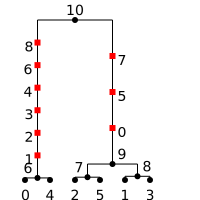

Variant	0	1556.5376146696508	('0', '1')	[0 1 1 1 0 1]
Variant	1	4485.169367399067	('0', '1')	[1 0 0 0 1 0]
Variant	2	9788.562881294638	('0', '1')	[1 0 0 0 1 0]
Variant	3	11759.025033097714	('0', '1')	[1 0 0 0 1 0]
Variant	4	11949.318321421742	('0', '1')	[1 0 0 0 1 0]
Variant	5	14321.766176726669	('0', '1')	[0 1 1 1 0 1]
Variant	6	31454.991386272013	('0', '1')	[1 0 0 0 1 0]
Variant	7	45125.69225626066	('0', '1')	[0 1 1 1 0 1]
Variant	8	49709.6843784675	('0', '1')	[1 0 0 0 1 0]


In [60]:
display(SVG(mut_tree_seq.first().draw()))
for variant in mut_tree_seq.variants():
  print("Variant", variant.site.id, variant.site.position,
        variant.alleles, variant.genotypes, sep="\t")

Here we have looped through each variant, printing out the observed state of each sample as an array of zeros and ones, along with the index and position of the corresponding mutation. In this example, the alleles are always '0' (the ancestral state) and '1' (the derived state), because we are simulating with the infinite sites mutation model, in which each mutation occurs at a unique position in the genome. More complex models are possible, however.

This way of working with the sequence data is quite efficient because we do not need to keep the entire genotype matrix in memory at once. However, if we do want the full genotype matrix it is simple to obtain:

In [62]:
A = mut_tree_seq.genotype_matrix()
A

NameError: name 'mut_tree_seq' is not defined

## Pairwise Diversity
We can determine pairwise genetic diversity from the simulation we loaded in the beginning of our notebook. 

In [0]:
#Load simulation, but for now just create a big new ts
simulation=msprime.simulate(sample_size=1000,Ne=10000,
                            length=1e5,mutation_rate=1e-8,
                            recombination_rate=1e-8,random_seed=10)


In [0]:
%%timeit
simulation.pairwise_diversity()

1000 loops, best of 3: 404 µs per loop


In [0]:
#todo: time with numpy pulling out genotype_matrix
geno_matrix = simulation.genotype_matrix()


## LD Plot
The msprime API provides methods to efficiently calculate population genetics statistics. For example, the LdCalculator class allows us to compute pairwise linkage disequilibrium coefficients. Here we use the get_r2_matrix() method to easily make an LD plot using matplotlib. (Thanks to the excellent scikit-allel for the basic plotting code used here.)

In [0]:
import msprime
import matplotlib.pyplot as pyplot

def ld_matrix_example():
    ts = msprime.simulate(100, recombination_rate=10, mutation_rate=20,
            random_seed=1)
    ld_calc = msprime.LdCalculator(ts)
    A = ld_calc.r2_matrix()
    # Now plot this matrix.
    x = A.shape[0] / pyplot.rcParams['figure.dpi']
    x = max(x, pyplot.rcParams['figure.figsize'][0])
    fig, ax = pyplot.subplots(figsize=(x, x))
    fig.tight_layout(pad=0)
    im = ax.imshow(A, interpolation="none", vmin=0, vmax=1, cmap="Blues")
    ax.set_xticks([])
    ax.set_yticks([])
    for s in 'top', 'bottom', 'left', 'right':
        ax.spines[s].set_visible(False)
    pyplot.gcf().colorbar(im, shrink=.5, pad=0)
    pyplot.savefig("ld.svg")

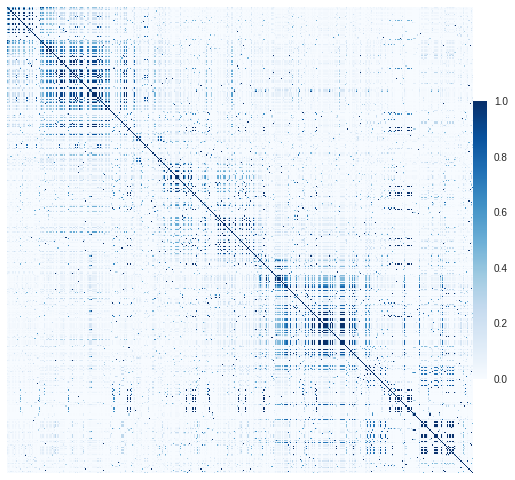

In [0]:
ld_matrix_example()

## SFS-like calculations

The site frequency spectrum (SFS) is the basis of many population genetic statistics. For example, Tajima's D is calculated by dividing the . There is a "branch length" equivalent to the . Essentially the value you would get with an infinite mutation rate.